# Get input data from the two pipelines

In [6]:
!gsutil cp gs://hca-dcp-mint-test-data/10x/pbmc8k/digital_expression.txt.gz optimus_pbmc8k.txt.gz 

Copying gs://hca-dcp-mint-test-data/10x/pbmc8k/digital_expression.txt.gz...
/ [1 files][ 95.5 MiB/ 95.5 MiB]                                                
Operation completed over 1 objects/95.5 MiB.                                     


In [9]:
!curl -o 10x_pbmc8k.tar.gz http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  7881k      0  0:00:04  0:00:04 --:--:-- 7882k


In [13]:
!tar -xzf 10x_pbmc8k.tar.gz

# Pre-process the data

In [32]:
import scipy.sparse as sp
import scanpy.api as sc
import pandas as pd
import numpy as np

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')

This code translates the awful dense matrix into something sparse that we can operate over. 

In [31]:
row = []
col = []
val = []
with open('optimus_pbmc8k.txt', 'r') as f:
    
    line_iterator = iter(f)
    row_ids = next(f).strip().split()[1:]
    col_ids = []
    
    for col_index, line in enumerate(line_iterator): 
        header, *data = line.strip().split()
        col_ids.append(header)
        data = np.fromiter(data, dtype=np.int32)
        row_inds = np.where(data)[0]
        vals = data[row_inds]
        row.extend(row_inds)
        col.extend([col_index] * row_inds.shape[0])
        val.extend(vals)
        if not col_index % 1000: 
            pass
#             print('%d columns parsed' % col_index)

Take the row, col, val and use those arrays to construct a coordinate sparse data structure. We then immediately wrap this in scanpy AnnData object. 

In [34]:
coo = sp.coo_matrix((val, (row,col)), dtype=np.int32)
col_ids = pd.read_csv('./row_ids.txt', header=0, squeeze=True)
adata = sc.AnnData(coo, obs=row_ids[1:], var=col_ids)

# Compare the library size distribution between the two datasets

In [78]:
tenx_data = sc.read_mtx('filtered_gene_bc_matrices/GRCh38/matrix.mtx')

In [50]:
optimus_counts = adata.X.tocsr().sum(axis=1)
tenx2_counts = tenx_data.X.tocsr().sum(axis=1)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'log10 molecule count')

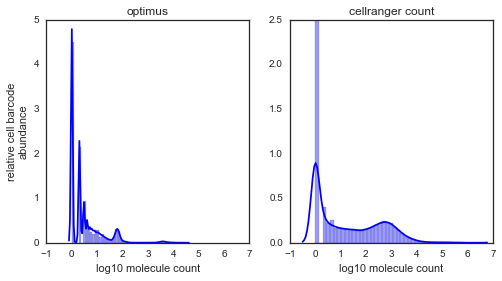

In [84]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

sns.distplot(np.log10(optimus_counts + 1), ax=ax1)
ax1.set_title('optimus')
ax1.set_xlabel('log10 molecule count')
ax1.set_ylabel('relative cell barcode\nabundance')
# ax1.set_xlim((-1, 7))


sns.distplot(np.log10(tenx2_counts + 1), ax=ax2)
ax2.set_title('cellranger count')
ax2.set_xlabel('log10 molecule count')
# ax2.set_ylabel('relative cell barcode\nabundance')
# ax1.set_xlim((-1, 7))

In [78]:
tenx_data = sc.read_mtx('filtered_gene_bc_matrices/GRCh38/matrix.mtx')